In [165]:
# import libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline


from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [166]:
# Test for the set n.2
dataset = pd.read_csv('/home/developer/Documents/Machine Learning/Corteva/dataset/cleaned/dryer_3_fan_1_2020.csv', sep=';', usecols = ['Motor_Frequency_Cmd_Hz','X_Axis_High_Frequency_RMS_Acceleration','X_Axis_RMS_Velocity', 'Z_Axis_High_Frequency_RMS_Acceleration', 'Z_Axis_RMS_Velocity'],)
# dataset.columns = ['Motor_Frequency_Cmd_Hz','Timestamp','X_Axis_High_Frequency_RMS_Acceleration','X_Axis_RMS_Velocity', 'Z_Axis_High_Frequency_RMS_Acceleration', 'Z_Axis_RMS_Velocity']
dataset.head()

,Motor_Frequency_Cmd_Hz,X_Axis_High_Frequency_RMS_Acceleration,X_Axis_RMS_Velocity,Z_Axis_High_Frequency_RMS_Acceleration,Z_Axis_RMS_Velocity
0,"32,8","0,232","0,326","0,169","3,305"
1,"32,8","0,233","0,38","0,171","1,335"
2,"40,2","1,047","0,538","0,511","0,456"
3,"40,2","1,155","0,572","0,516","0,376"
4,"40,2","0,773","0,605","0,47","0,363"


In [167]:
# Convert values with comma into float
dataset['X_Axis_High_Frequency_RMS_Acceleration'] = dataset['X_Axis_High_Frequency_RMS_Acceleration'].astype(str).str.replace(',', '.').astype(float)
dataset['X_Axis_RMS_Velocity'] = dataset['X_Axis_RMS_Velocity'].astype(str).str.replace(',', '.').astype(float)
dataset['Z_Axis_High_Frequency_RMS_Acceleration'] = dataset['Z_Axis_High_Frequency_RMS_Acceleration'].astype(str).str.replace(',', '.').astype(float)
dataset['Z_Axis_RMS_Velocity'] = dataset['Z_Axis_RMS_Velocity'].astype(str).str.replace(',', '.').astype(float)
dataset['Motor_Frequency_Cmd_Hz'] = dataset['Motor_Frequency_Cmd_Hz'].astype(str).str.replace(',', '.').astype(float)
dataset

,Motor_Frequency_Cmd_Hz,X_Axis_High_Frequency_RMS_Acceleration,X_Axis_RMS_Velocity,Z_Axis_High_Frequency_RMS_Acceleration,Z_Axis_RMS_Velocity
0,32.8,0.232,0.326,0.169,3.305
1,32.8,0.233,0.380,0.171,1.335
2,40.2,1.047,0.538,0.511,0.456
3,40.2,1.155,0.572,0.516,0.376
4,40.2,0.773,0.605,0.470,0.363
...,...,...,...,...,...
2690,44.0,1.340,1.607,1.053,1.264
2691,44.0,1.441,1.786,1.060,2.514
2692,44.0,1.408,1.395,1.047,1.718
2693,44.0,1.363,2.217,1.085,3.470


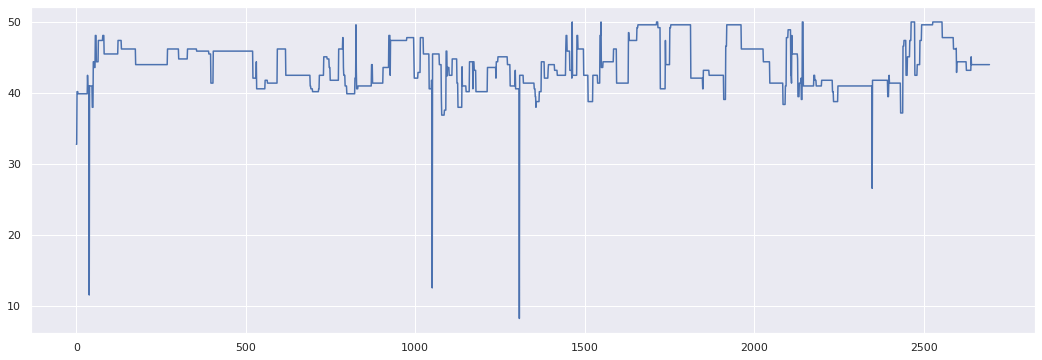

In [168]:
dataset['Motor_Frequency_Cmd_Hz'].plot(figsize=(18,6));


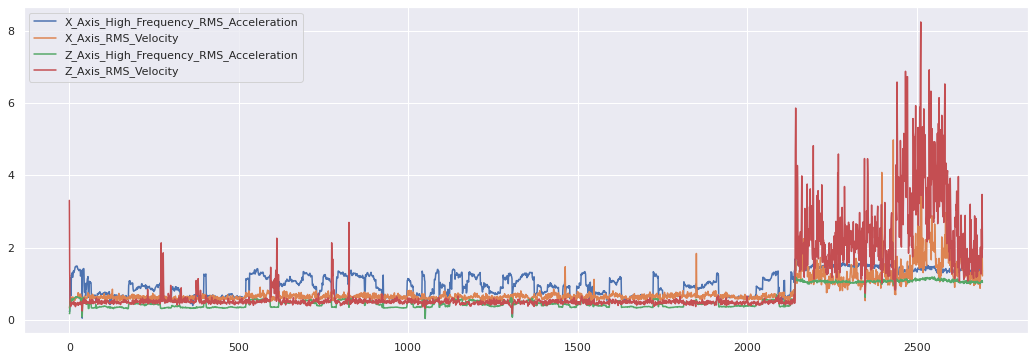

In [169]:
dataset[['X_Axis_High_Frequency_RMS_Acceleration', 'X_Axis_RMS_Velocity', 'Z_Axis_High_Frequency_RMS_Acceleration', 'Z_Axis_RMS_Velocity']].plot(figsize=(18,6));


In [170]:
# Split trainig set and test set

# Training set
training_set = dataset[0:2092]
training_set

,Motor_Frequency_Cmd_Hz,X_Axis_High_Frequency_RMS_Acceleration,X_Axis_RMS_Velocity,Z_Axis_High_Frequency_RMS_Acceleration,Z_Axis_RMS_Velocity
0,32.8,0.232,0.326,0.169,3.305
1,32.8,0.233,0.380,0.171,1.335
2,40.2,1.047,0.538,0.511,0.456
3,40.2,1.155,0.572,0.516,0.376
4,40.2,0.773,0.605,0.470,0.363
...,...,...,...,...,...
2087,38.4,1.252,0.518,0.688,0.554
2088,38.4,1.265,0.619,0.626,0.505
2089,38.4,1.314,0.566,0.623,0.617
2090,38.4,1.301,0.587,0.609,0.590


In [171]:
# Test set
test_set = dataset[2093: ]
test_set

,Motor_Frequency_Cmd_Hz,X_Axis_High_Frequency_RMS_Acceleration,X_Axis_RMS_Velocity,Z_Axis_High_Frequency_RMS_Acceleration,Z_Axis_RMS_Velocity
2093,41.0,0.870,0.636,0.507,0.514
2094,41.0,0.895,0.621,0.470,0.439
2095,47.8,0.546,0.746,0.369,0.537
2096,47.8,0.541,0.724,0.362,0.573
2097,47.8,0.546,0.700,0.359,0.497
...,...,...,...,...,...
2690,44.0,1.340,1.607,1.053,1.264
2691,44.0,1.441,1.786,1.060,2.514
2692,44.0,1.408,1.395,1.047,1.718
2693,44.0,1.363,2.217,1.085,3.470


In [174]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(training_set)
X_test = scaler.transform(test_set)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)



['scaler_data']

In [175]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)


Training data shape: (2092, 1, 5)
Test data shape: (602, 1, 5)


In [176]:
X_train

array([[[0.58752998, 0.13655172, 0.08323208, 0.19907407, 1.        ]],

       [[0.58752998, 0.13724138, 0.11603888, 0.20216049, 0.37281121]],

       [[0.76498801, 0.69862069, 0.21202916, 0.72685185, 0.09296402]],

       ...,

       [[0.72182254, 0.88275862, 0.2290401 , 0.89969136, 0.14422159]],

       [[0.72182254, 0.8737931 , 0.2417983 , 0.87808642, 0.1356256 ]],

       [[0.72182254, 0.90827586, 0.26063183, 0.9058642 , 0.13307864]]])

In [177]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model





In [178]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()





Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1, 5)]            0         
                                                                 
 lstm_20 (LSTM)              (None, 1, 16)             1408      
                                                                 
 lstm_21 (LSTM)              (None, 4)                 336       
                                                                 
 repeat_vector_5 (RepeatVect  (None, 1, 4)             0         
 or)                                                             
                                                                 
 lstm_22 (LSTM)              (None, 1, 4)              144       
                                                                 
 lstm_23 (LSTM)              (None, 1, 16)             1344      
                                                           

In [179]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history




Epoch 1/100
199/199 [==============================] - 10s 16ms/step - loss: 0.3127 - val_loss: 0.0682
Epoch 2/100
199/199 [==============================] - 1s 7ms/step - loss: 0.0646 - val_loss: 0.0603
Epoch 3/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0561 - val_loss: 0.0542
Epoch 4/100
199/199 [==============================] - 1s 7ms/step - loss: 0.0481 - val_loss: 0.0438
Epoch 5/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0398 - val_loss: 0.0382
Epoch 6/100
199/199 [==============================] - 1s 7ms/step - loss: 0.0316 - val_loss: 0.0275
Epoch 7/100
199/199 [==============================] - 1s 7ms/step - loss: 0.0243 - val_loss: 0.0250
Epoch 8/100
199/199 [==============================] - 1s 6ms/step - loss: 0.0220 - val_loss: 0.0231
Epoch 9/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0217 - val_loss: 0.0218
Epoch 10/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0215 - val_

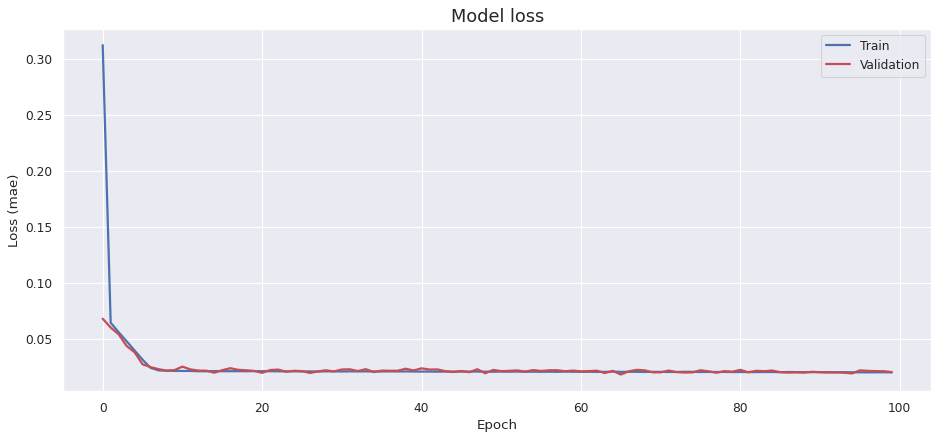

In [180]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(0.0, 0.5)

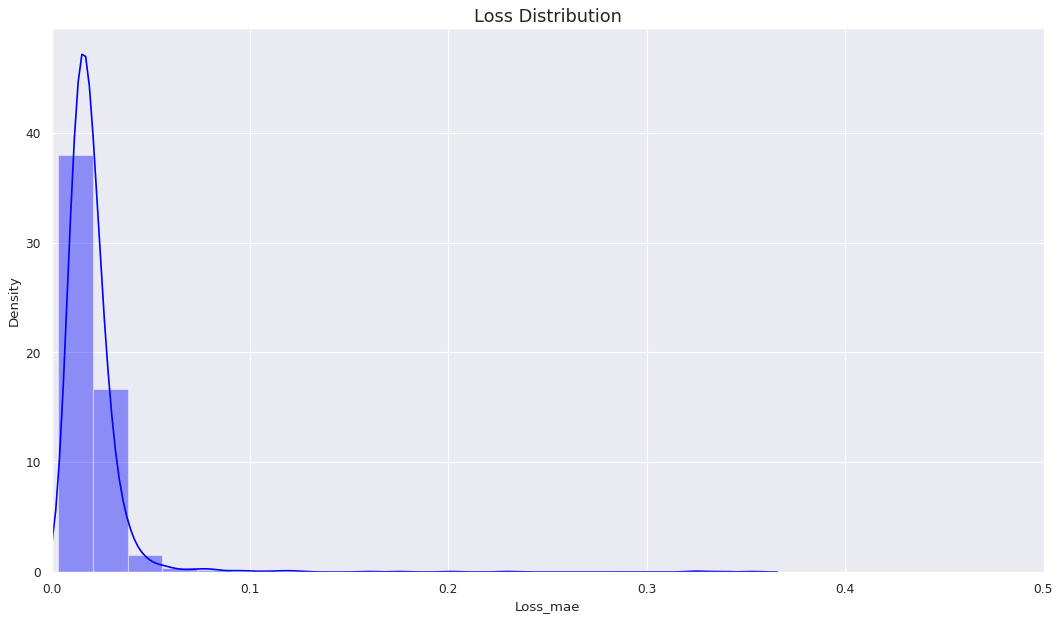

In [211]:
# Distribution of Loss Function

# By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly.


# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=training_set.columns)
X_pred.index = training_set.index

scored = pd.DataFrame(index=training_set.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])



In [212]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test_set.columns)
X_pred.index = test_set.index

scored = pd.DataFrame(index=test_set.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.10
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()


,Loss_mae,Threshold,Anomaly
2093,0.042394,0.1,False
2094,0.031467,0.1,False
2095,0.037537,0.1,False
2096,0.034987,0.1,False
2097,0.026520,0.1,False


In [213]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=training_set.columns)
X_pred_train.index = training_set.index

scored_train = pd.DataFrame(index=training_set.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.10
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

<AxesSubplot:>

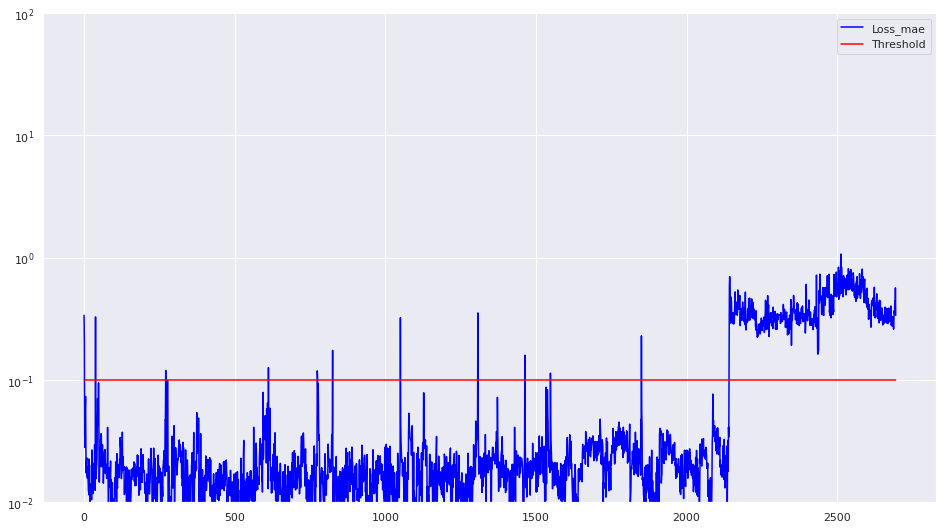

In [214]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])